In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Voroni around raw points

We perform the following:

- Merge points which are really close together
- From the merged points, form the Voroni diagram
- Re-distribute points within each Voroni cell

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import impute.san_francisco as sf
import impute.geometry
import impute.voroni
import bz2
import pandas as pd
import geopandas as gpd
import shapely.geometry
import descartes
import pyproj
proj = pyproj.Proj({"init":"EPSG:2768"})

In [3]:
datadir = os.path.join("/media", "disk", "Data")
filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
def gen():
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from sf.load(f)

next(gen())

Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42158168137, 37.7617007179518), idd='15006027571000', incident='150060275')

# Visualise

Load the data to a geo data frame, and save so we can view in QGIS

In [4]:
with bz2.open(filename, "rt", encoding="UTF8") as f:
    frame = sf.to_geoframe(f, lambda r : r.category=="BURGLARY")
frame.head()

,category,description,datetime,block,idd,geometry
0,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",2015-01-31 16:09:00,200 Block of STOCKTON ST,15009825405053,POINT (-122.40656817787 37.7878092959561)
1,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",2015-01-30 12:30:00,2600 Block of 18TH ST,15009883405073,POINT (-122.40867573409 37.761791195706)
2,BURGLARY,"BURGLARY OF APARTMENT HOUSE, FORCIBLE ENTRY",2015-02-01 13:15:00,1800 Block of WAWONA ST,15009930905011,POINT (-122.486177330467 37.7368129188976)
3,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",2015-02-02 00:50:00,400 Block of VALENCIA ST,15009954705051,POINT (-122.42207304894 37.7661259454801)
4,BURGLARY,"BURGLARY OF RESIDENCE, UNLAWFUL ENTRY",2015-02-01 21:00:00,300 Block of LEXINGTON ST,15009980405043,POINT (-122.420489911989 37.7577269207659)


In [5]:
frame = frame.drop(["category", "description", "idd"], axis=1)
frame.datetime = frame.datetime.map(lambda x : str(x))
#frame.to_file("burglary")

# Place into a voroni diagram

In [4]:
points = np.asarray([row.point for row in gen()])
xcs, ycs = proj(*points.T)
points = np.asarray([xcs, ycs]).T

In [5]:
voroni = impute.voroni.Voroni(points, tolerance=1)

## Visualise

Convert to "web mercator" and plot

In [6]:
import open_cp.geometry
import matplotlib.patches
import tilemapbase

def project_to_wm(xcs, ycs):
    xcs, ycs = proj(xcs, ycs, inverse=True)
    points = [tilemapbase.project(x, y) for x, y in zip(xcs, ycs)]
    return np.asarray(points)

pts_wm = project_to_wm(xcs, ycs)

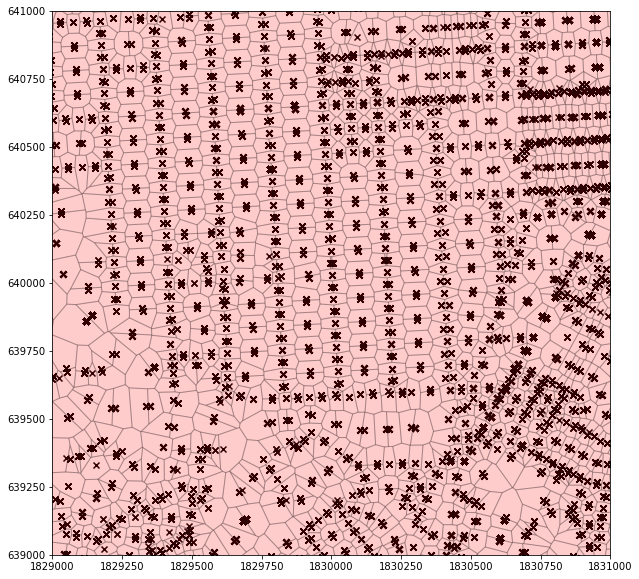

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

for p in voroni.all_polygons():
    poly = matplotlib.patches.Polygon(p, ec="black", fc="red", alpha=0.2)
    ax.add_patch(poly)
    
ax.scatter(xcs, ycs, marker="x", color="black")
si = 1000
x, y = 1830000, 640000
ax.set(xlim=[x-si,x+si], ylim=[y-si,y+si])
None

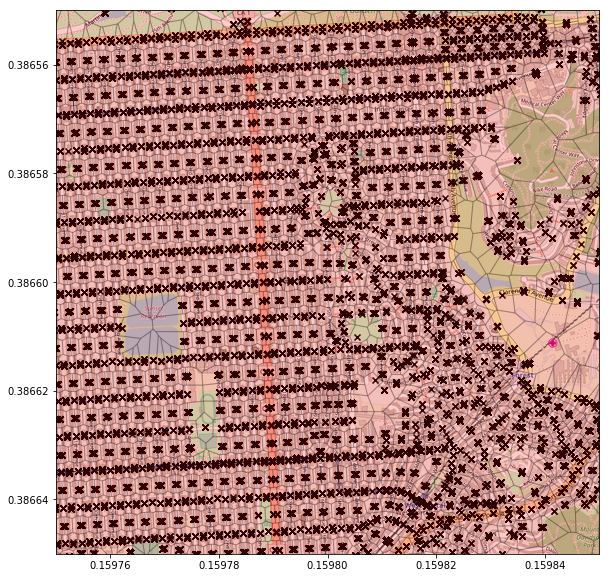

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in voroni.all_polygons():
    p = project_to_wm(*np.asarray(p).T)
    poly = matplotlib.patches.Polygon(p, ec="black", fc="red", alpha=0.2)
    ax.add_patch(poly)
    
ax.scatter(*pts_wm.T, marker="x", color="black")
None

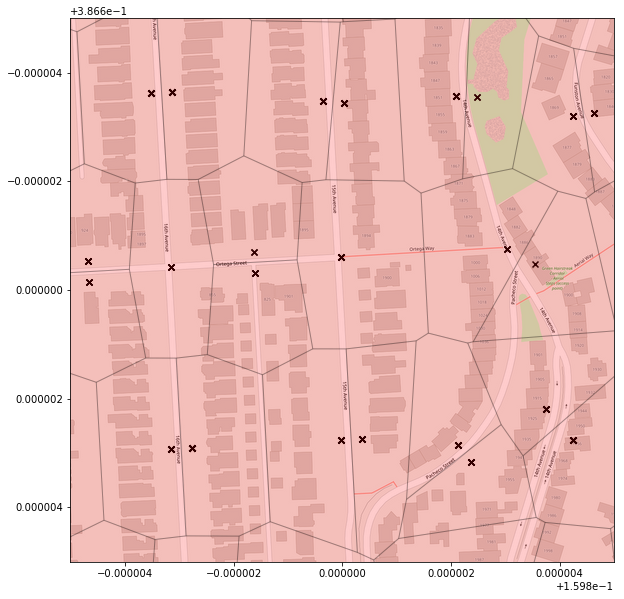

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in voroni.all_polygons():
    p = project_to_wm(*np.asarray(p).T)
    poly = matplotlib.patches.Polygon(p, ec="black", fc="red", alpha=0.2)
    ax.add_patch(poly)
    
ax.scatter(*pts_wm.T, marker="x", color="black")
None

## Small regions

Check how small regions get.  There are some small regions, but not excessively so.

In [25]:
polys = [shapely.geometry.Polygon(p) for p in voroni.all_polygons()]
min([p.area for p in polys])

63.02040149529562

## Clip to outline

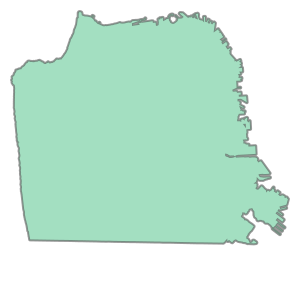

In [26]:
datadir = os.path.join("/media", "disk", "Data")
frame = gpd.io.file.read_file(os.path.join(datadir, "SF_Neighborhood_Quadrants.geojson"))
frame = frame.to_crs({"init":"EPSG:2768"})
sanfran_geo = frame.unary_union
outline = sanfran_geo.buffer(45)
outline

# Which points do we miss?

Check that the only points we miss are well away from the "outline" geometry-- they are all on Treasure Island in fact.

In [27]:
redist = voroni.to_redistributor(outline)

In [28]:
unique_pts = list(set(zip(xcs, ycs)))

no_poly = []
for i, pt in enumerate(unique_pts):
    options = redist.find_containing_polygon(*pt)
    if len(options) == 0:
        pt = shapely.geometry.Point(*pt)
        print(pt,
              sum(p.intersects(pt) for p in redist.polygons),
              min(pt.distance(p) for p in redist.polygons),
            outline.distance(pt))
    elif len(options) > 1:
        raise AssertionError()

POINT (1834998.780837009 648144.6505023644) 0 2653.476173861378 2653.476173861378
POINT (1835742.642137041 646985.8780023658) 0 2685.677991920288 2685.677991920288
POINT (1835153.464435619 647846.1709451119) 0 2642.253801999914 2642.253801999914
POINT (1835153.464433339 647846.1709456345) 0 2642.2538004336566 2642.2538004336566
POINT (1835799.102637074 647044.0014023748) 0 2766.6313272423963 2766.6313272423963
POINT (1835294.855637057 647552.0691023718) 0 2582.6093522220485 2582.6093522220485
POINT (1834987.929437079 648139.0923023679) 0 2641.303931777841 2641.303931777841
POINT (1835249.66513704 647625.3776023726) 0 2591.81797451608 2591.81797451608
POINT (1835207.849337054 647784.9839023653) 0 2652.6492101268395 2652.6492101268395
POINT (1835772.009137015 647024.5280023684) 0 2734.079607068443 2734.079607068443
POINT (1835838.580537008 648199.5101023744) 0 3407.3391172806737 3407.3391172806737


# Visualise redistribution

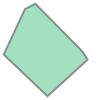

In [34]:
x, y = voroni.merged_points[0]
assert redist.find_containing_polygon(x, y) == [0]
poly = redist.polygons[0]
poly

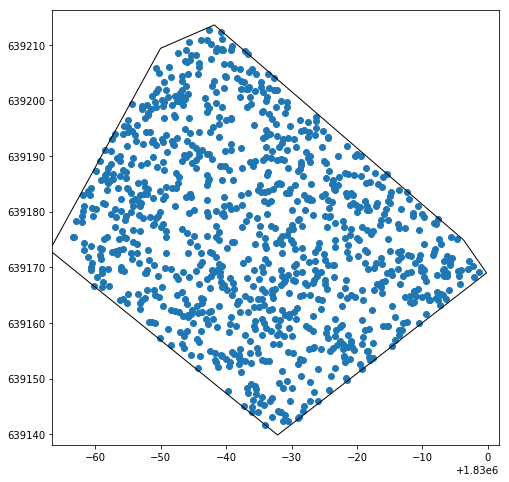

In [35]:
pts = np.asarray(redist.redistribute_from_poly(0, 1000))

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*pts.T)
ax.add_patch(descartes.PolygonPatch(poly, fc="none"))

# Make some new points

In [36]:
redist = impute.geometry.CachingRedistributor(redist.polygons)

## Visualise

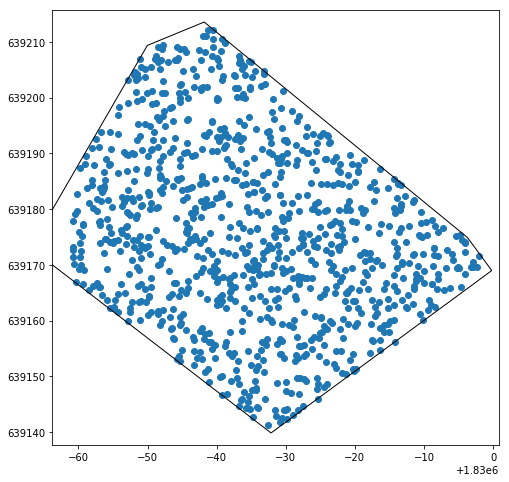

In [37]:
pts = np.asarray(redist.redistribute_from_poly(0, 1000))

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*pts.T)
ax.add_patch(descartes.PolygonPatch(poly, fc="none"))

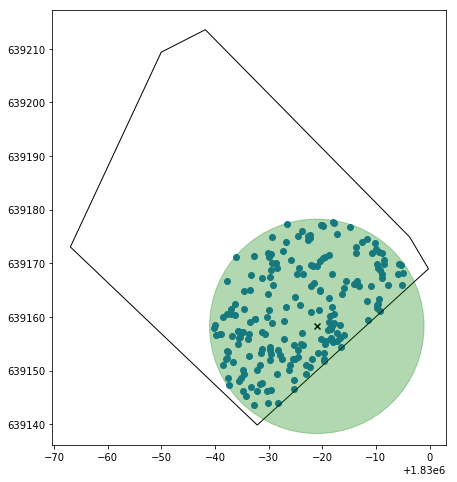

In [38]:
x, y = voroni.merged_points[0]
assert redist.find_containing_polygon(x, y) == [0]
pts = np.asarray([redist.redistribute_within_radius(x, y, 20) for _ in range(200)])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*pts.T)
ax.add_patch(descartes.PolygonPatch(poly, fc="none"))
ax.scatter(x, y, marker="x", color="black")
ax.add_patch(matplotlib.patches.Circle([x,y], 20, alpha=0.3, color="green"))
ax.set_aspect(1)
None

## Do the job...

In [31]:
total = len(list(gen()))

In [32]:
missing_count = 0
new_data, old_data = [], []
for row in gen():
    x, y = proj(*row.point)
    pt = redist.redistribute_within_radius(x, y, 100)
    if pt is None:
        missing_count += 1
        continue
    t = list(tuple(row))
    t[4] = pt
    newrow = impute.san_francisco.Row(*t)
    new_data.append(newrow)
    t = list(tuple(row))
    t[4] = x, y
    old_data.append(impute.san_francisco.Row(*t))
    if len(new_data) % 1000 == 0:
        print(len(new_data) + missing_count, total, file=sys.__stdout__)
missing_count

3992

In [33]:
new_data[0], old_data[0]

(Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(1830703.9831515444, 641773.01405028265), idd='15006027571000'),
 Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(1830701.9558046926, 641762.8651285049), idd='15006027571000'))

## Save out

In [34]:
import bz2, datetime, csv

In [35]:
outfilename = os.path.join(datadir, "sf_imputed.csv.bz2")
with bz2.open(outfilename, "wt") as file:
    writer = csv.writer(file)
    writer.writerow(["category", "description", "datetime", "block", "point", "idd"])
    for row in new_data:
        writer.writerow(list(row))
os.stat(filename).st_size / 1024 / 1024

67.63947677612305

Some sanity checking...

In [36]:
with bz2.open(outfilename, "rt") as file:
    new_new_data = []
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        row = list(row)
        row[2] = datetime.datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S")
        x, y = [float(x.strip()) for x in row[4][1:-1].split(",")]
        row[4] = (x, y)
        row = impute.san_francisco.Row(*row)
        new_new_data.append(row)

In [37]:
assert len(new_data) == len(new_new_data)
for row, row1 in zip(new_data, new_new_data):
    assert row==row1

## Visualise

In [38]:
assert len(old_data) == len(new_data)
for row, row1 in zip(old_data, new_data):
    assert row.category == row1.category
    assert row.description == row1.description
    assert row.datetime == row1.datetime
    assert row.block == row1.block
    assert row.idd == row1.idd

In [39]:
move_frame = gpd.GeoDataFrame({
    #"category" : [row.category for row in new_data],
    #"description" : [row.description for row in new_data],
    #"datetime" : [str(row.datetime) for row in new_data],
    "block" : [row.block for row in new_data],
    # idd
    })
move_frame.geometry = [
    shapely.geometry.LineString([row.point, row1.point])
    for row, row1 in zip(old_data, new_data) ]
move_frame.crs = {"init":"EPSG:2768"}
move_frame.head()

,block,geometry
0,18TH ST / VALENCIA ST,LINESTRING (1830701.955804693 641762.865128504...
1,300 Block of LEAVENWORTH ST,LINESTRING (1831385.123537081 644245.423502374...
2,300 Block of LEAVENWORTH ST,LINESTRING (1831385.123537081 644245.423502374...
3,300 Block of LEAVENWORTH ST,LINESTRING (1831385.123537081 644245.423502374...
4,LOMBARD ST / LAGUNA ST,LINESTRING (1829950.622301981 646081.889769603...


In [40]:
move_frame.to_file("sf_moves")

In [41]:
pts_frame = gpd.GeoDataFrame({
    "block" : [row.block for row in new_data]
    })
pts_frame.geometry = [shapely.geometry.Point(*row.point) for row in new_data]
pts_frame.crs = {"init":"EPSG:2768"}
pts_frame.to_file("sf_new_pts")

### Visualise the polygons

In [42]:
poly_frame = gpd.GeoDataFrame({"num" : list(range(len(redist.polygons)))})
poly_frame.geometry = list(redist.polygons)
poly_frame.crs = {"init":"EPSG:2768"}
poly_frame.to_file("sf_polygons")